# Финальный проект **Телеком**
  - Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

  ## Цель проекта
  Разработать модель предсказания оттока клиентов с достигнутой ключевой метрикой roc_auc не менее 0.85

- Импортируем необходимые инструменты и библиотеки в сверхнюю ячейку.
- Откроем датасеты.

In [ ]:
pip install catboost

In [ ]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer

from numpy.random import RandomState

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score, precision_score
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix

RANDOM_STATE = 310723

In [ ]:
data_c = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
data_p = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
data_i = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
data_t = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

for i in (data_c, data_p, data_i, data_t,):
    display(i.head())
    print("")
    i.info()
    print('Duplicated:', i.duplicated().sum())
    #print('Null:', i.isna().sum())
    print('_______________________')


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
Duplicated: 0
_______________________


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Duplicated: 0
_______________________


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Duplicated: 0
_______________________


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Duplicated: 0
_______________________


Откроем и изучим данные четырех таблиц - это:
  - data_c информация о договоре
      - BeginDate - дата начала пользования услугами
      - **EndDate** - дата окончания пользования
      - Type - тип договора
      - PaperlessBilling - факт выставления счета на электронную почту
      - PaymentMethod - способ оплаты
      - MonthlyCharges - ежемесячные траты на услуги,
      - TotalCharges - всего потрачено денег на услуги,
  - data_p персональные данные клиента
      - Dependents - наличие иждивенцев
      - gender — пол;
      - SeniorCitizen — является ли абонент пенсионером;
      - Partner — есть ли у абонента супруг или супруга;
  - data_i информация об интернет-услугах
      - InternetService - оптоволоконный кабели или цифровой
      - OnlineSecurity — блокировка опасных сайтов;
      - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
      - DeviceProtection — антивирус;
      - TechSupport — выделенная линия технической поддержки;
      - StreamingTV — стриминговое телевидение;
      - StreamingMovies — каталог фильмов.
  - data_t информация об услугах телефонии
      - MultipleLines - наличие возможности ведения параллельных линий


      

### Объединим датасеты в один для того что бы было удобнее анализировать данные целиком

In [ ]:
data_full = data_c.merge(data_p, on = 'customerID', how ='left')
data_f = data_full.merge(data_i, on = 'customerID', how ='left')
data = data_f.merge(data_t, on = 'customerID', how ='left')

In [ ]:
data.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
865,3671-SHRSP,2019-08-01,No,Month-to-month,Yes,Mailed check,80.60,488.44,Male,0,Yes,No,Fiber optic,No,No,Yes,Yes,No,No,No
3365,3865-ZFZIB,2018-07-01,No,Two year,No,Mailed check,19.65,373.35,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6497,4062-HBMOS,2015-10-01,No,Month-to-month,Yes,Electronic check,103.05,5358.6,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
1042,7296-PIXQY,2018-12-01,No,Month-to-month,No,Electronic check,70.20,1041.77,Female,0,Yes,Yes,Fiber optic,No,No,No,No,No,No,No
1704,0107-YHINA,2019-10-01,No,Month-to-month,Yes,Electronic check,99.75,402.99,Male,0,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Yes


In [ ]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Образовалось довольно много пропусков NaN полсе объединения таблиц. Учитывая что данных слишком мало мы можем только заменить пропуски значениями-заглушками по типу unknown

In [ ]:
list_for_full = data[['InternetService',
                      'OnlineSecurity',
                      'OnlineBackup',
                      'DeviceProtection',
                      'TechSupport',
                      'StreamingTV',
                      'StreamingMovies',
                      'MultipleLines']]

data[list_for_full.columns] = list_for_full.fillna('unknown')

In [ ]:
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [ ]:
data.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2275,7180-PISOG,2019-11-01,No,Month-to-month,Yes,Electronic check,74.50,223.5,Male,0,Yes,Yes,Fiber optic,No,No,No,No,No,No,Yes
817,0036-IHMOT,2015-07-01,No,One year,Yes,Bank transfer (automatic),103.70,5931.64,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,No
5021,6617-WLBQC,2018-03-01,No,One year,No,Credit card (automatic),81.85,1920.2,Female,0,Yes,Yes,Fiber optic,Yes,No,No,No,No,No,Yes
1932,3247-MHJKM,2020-01-01,No,Month-to-month,No,Mailed check,20.20,20.81,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
3937,5712-VBOXD,2019-10-01,No,Month-to-month,Yes,Credit card (automatic),20.15,88.66,Female,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No


Судя по срезу данных пропуски образовались по причине того что клиент новый и по нему еще не сформировано досье: у клиента который зарегистрирован в 2019 году отсутсвует информация об интернет услугах, в то время как у пользователя зарегистрированно в 2018 году эти данные есть.

План дальнейшей работы:
 - Привести название колонок к нижнему регистру для удобства
 - Приступить к визуализации и описанию данных
 - Проверить есть ли аномалии в даных
 - Сгенерировать портрет пользователя (посмотрим какие признаки помогают понять что из себя представляет клиент)
 - Создам новый признак - длительность сотрудничества (из колонки с датой вытащим кол-во дней которое человек является клиентом компании)
 - За целевой признак будет отвечает колонка **EndDate** которая дает понять клиент еще с нами или уже нет
 - Делим датасет на 2 выборки - train/test (0.25)
 - Кодируем признаки методом OneHotEncoder
 - Рассмотрим модели: ***LogisticRegression***, ***RandomForest*** , ***CatBoost*** и ***LGBM***
 - Буду масштабировать численные признаки StandartScaler
 - С дисбалансом не борюсь поскольку на метрику roc_auc не влияет дисбаланс
 - Подбираю гиперпараметры с помощью GridSearchCv
 - Поскольку нет валидационной выборки используем кросс-валидацию CV и качество модели смотрим по _best_score_
 - Оцениваю по ключевой метрике ROC_AUC (не менее 0.85)
 - После разработки модели лучшую тестирую на тестовой выборке методом predict_proba
 - Анализ лучшей модели (важность признаков, матрица ошибок)


## Предобработка данных

Приводим к нижнему регистру название колонок

In [ ]:
data.columns = data.columns.str.lower()

Скопируем датасет для исследовательского анализа

In [ ]:
data_2 = data.copy()

Ислледуем продолжительность клиентского периода

In [ ]:
data_2.begindate = pd.to_datetime(data_2.begindate)

In [ ]:
data_2.sample(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
2889,9830-ECLEN,2015-04-01,2018-01-01,One year,No,Mailed check,50.00,1749.0,Male,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,No,unknown
2698,8150-QUDFX,2019-12-01,No,Month-to-month,No,Mailed check,19.85,39.7,Male,0,No,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
3185,9907-SWKKF,2019-10-01,No,Month-to-month,No,Mailed check,25.05,100.2,Female,1,No,No,DSL,No,No,No,No,No,No,unknown
5293,2242-MFOTG,2017-05-01,No,One year,No,Bank transfer (automatic),80.10,2643.3,Male,0,No,No,Fiber optic,Yes,No,No,No,No,No,Yes
3886,3786-WOVKF,2014-02-01,No,One year,Yes,Bank transfer (automatic),106.85,8154.79,Female,1,Yes,No,Fiber optic,Yes,Yes,No,No,Yes,Yes,Yes
4623,8755-IWJHN,2014-05-01,No,Month-to-month,Yes,Bank transfer (automatic),95.35,6579.15,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
5809,8132-YPVBX,2019-08-01,No,Month-to-month,Yes,Mailed check,85.95,515.7,Female,0,No,No,Fiber optic,No,Yes,No,No,No,Yes,No
1369,5478-JJVZK,2017-05-01,No,Month-to-month,Yes,Mailed check,60.90,2009.7,Female,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes
4879,4501-UYKBC,2016-04-01,No,One year,Yes,Credit card (automatic),69.10,3178.6,Female,1,No,No,DSL,No,No,Yes,Yes,No,Yes,Yes
238,0094-OIFMO,2018-12-01,No,Month-to-month,Yes,Electronic check,95.00,1330.0,Female,1,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,No


In [ ]:
last_upload = data_2.begindate.max()
print('Дата последней выгрузки:', last_upload)

Дата последней выгрузки: 2020-02-01 00:00:00


In [ ]:
#выгрузка месяца в колонку start
data_2['start_month'] = data_2.begindate.dt.month

In [ ]:
data_2['enddate'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: enddate, Length: 67, dtype: int64

Агализ "устойчивости" клиентов

In [ ]:
def analys_clients(col):
    if col == 'No':
        return 'No'
    if col != 'No':
        return 'Yes'
data_2['enddate_encode'] = data_2.enddate.apply(analys_clients)

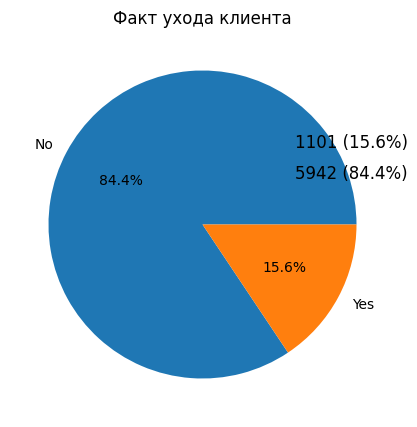

In [ ]:
plt.figure(figsize=(5, 5))

data_2['enddate_encode'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Факт ухода клиента')
plt.ylabel('')

counts = data_2['enddate_encode'].value_counts()
for i, count in enumerate(counts):
    plt.text(0.6, 0.3 + i * 0.2, f'{count} ({count / len(data_2) * 100:.1f}%)', fontsize=12)
plt.show()

После подписания контракта 84% клиентов продолжают сотрудничать с компанией

In [ ]:
data_2.enddate_encode.value_counts()

No     5942
Yes    1101
Name: enddate_encode, dtype: int64

In [ ]:
data_2['enddate'].value_counts()


No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: enddate, Length: 67, dtype: int64

In [ ]:
#делаем кодировку для анализа дней
data_2['encode'] = data_2.enddate.copy()
data_2.encode = data_2.encode.replace({'No': '2020-02-01'})
data_2.encode = pd.to_datetime(data_2.encode, format='%Y-%m-%d')

In [ ]:
data_2.encode = data_2.encode.astype('datetime64')

<ipython-input-25-a957e9be3063>:1: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  data_2.encode = data_2.encode.astype('datetime64')


In [ ]:
data_2.encode.value_counts()

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: encode, Length: 67, dtype: int64

In [ ]:
#достаем месяц из колонки с конечными датами и записываем  в колонку end_month
data_2['end_month'] = data_2.encode.dt.month

In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   7043 non-null   object        
 13  onlinesecurity    7043 non-null   object        
 14  onlinebackup      7043 n

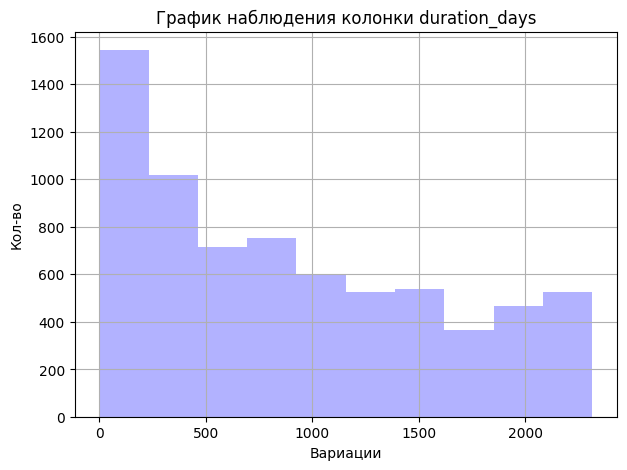

In [ ]:
#вычисляем количество дней клиента в компании
data_2['duration_days'] = (data_2.encode - data_2.begindate).dt.days
#data_2.duration_days.hist(alpha=0.6, bins=20, align='left');

plt.figure(figsize=(7, 5))
data_2.duration_days.hist(color='blue', alpha=0.3)
plt.title('График наблюдения колонки duration_days')
plt.xlabel('Вариации')
plt.ylabel('Кол-во')
plt.show()

In [ ]:
print('Медиана нахождения клиента в компании:', round(data_2.duration_days.median() / 365, 1), 'года')

Медиана нахождения клиента в компании: 2.1 года


In [ ]:
print('Максимальное время нахождения клиента в компании:', round(data_2.duration_days.max() / 365, 1), 'года')

Максимальное время нахождения клиента в компании: 6.3 года


Судя по графику есть нулевые значения - то есть либо не успел стать клиентом, либо никакой информации по этому id нет

In [ ]:
print('Нулевые клиенты:', (data_2['duration_days'] == 0).sum())
data_2 = data_2[data_2['duration_days'] != 0]
print('После удаления:', (data_2['duration_days'] == 0).sum())

Нулевые клиенты: 11
После удаления: 0


### Анализ признаков

Month-to-month    3875
Two year          1685
One year          1472
Name: type, dtype: int64


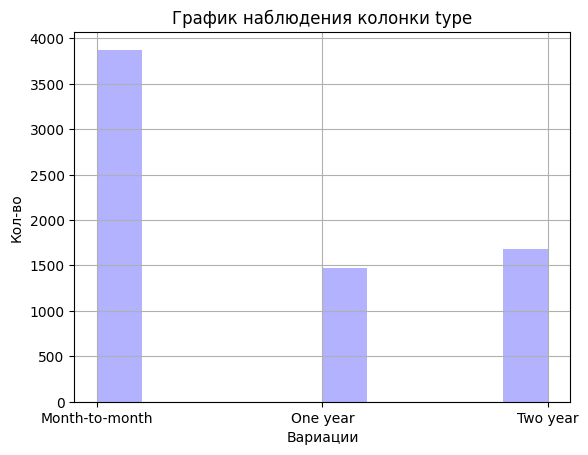

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: paymentmethod, dtype: int64


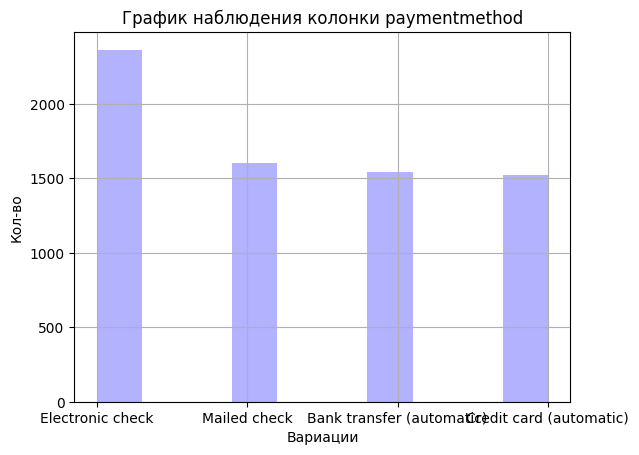

Male      3549
Female    3483
Name: gender, dtype: int64


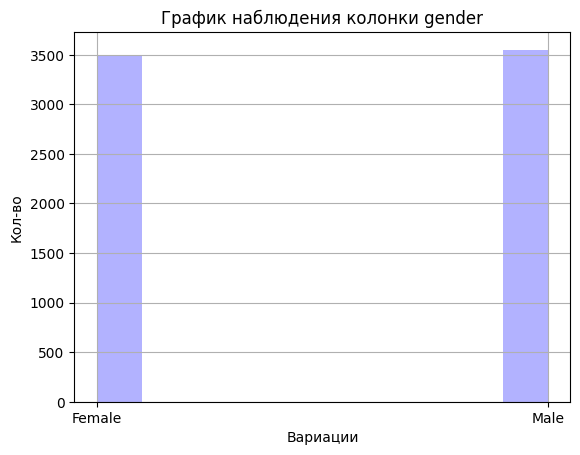

No     3639
Yes    3393
Name: partner, dtype: int64


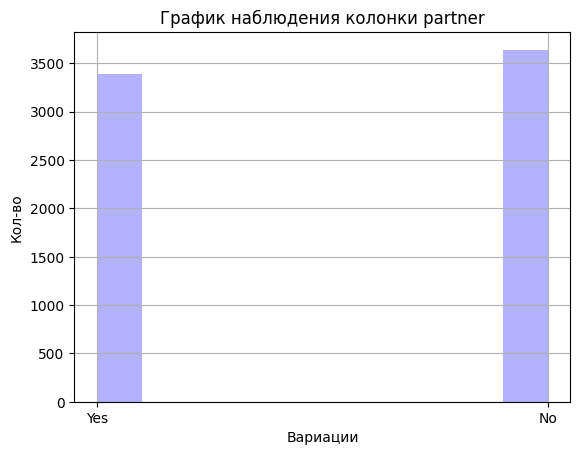

No     4933
Yes    2099
Name: dependents, dtype: int64


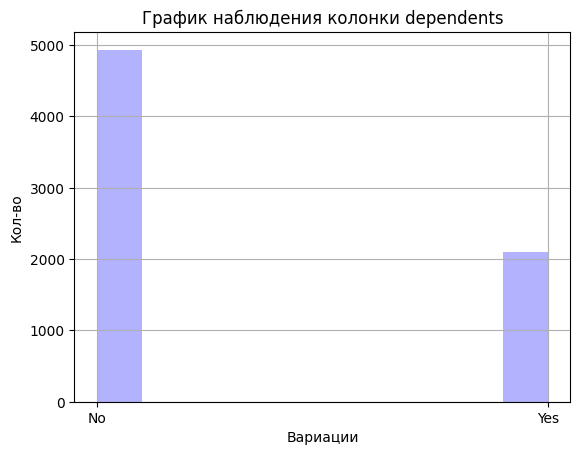

Fiber optic    3096
DSL            2416
unknown        1520
Name: internetservice, dtype: int64


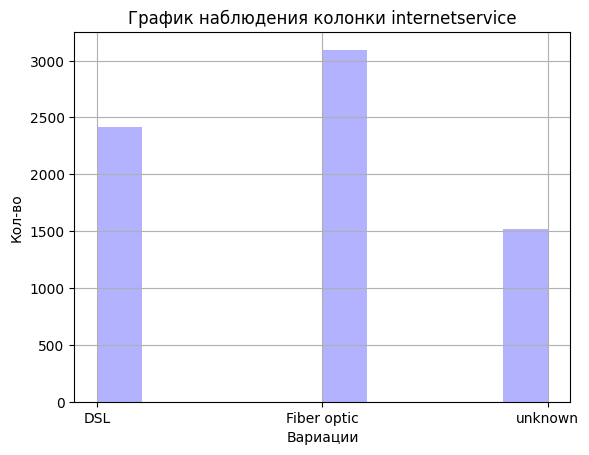

No         3497
Yes        2015
unknown    1520
Name: onlinesecurity, dtype: int64


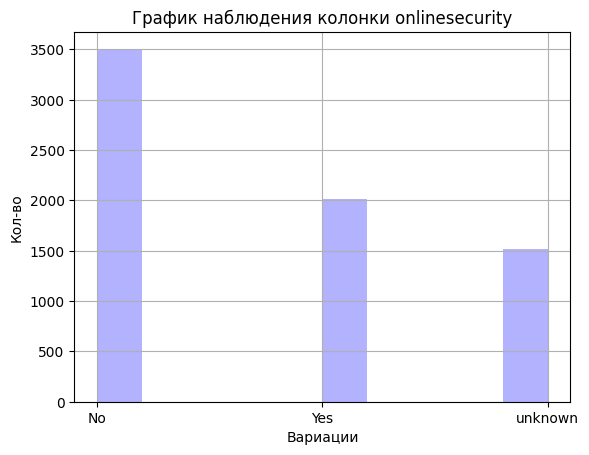

No         3087
Yes        2425
unknown    1520
Name: onlinebackup, dtype: int64


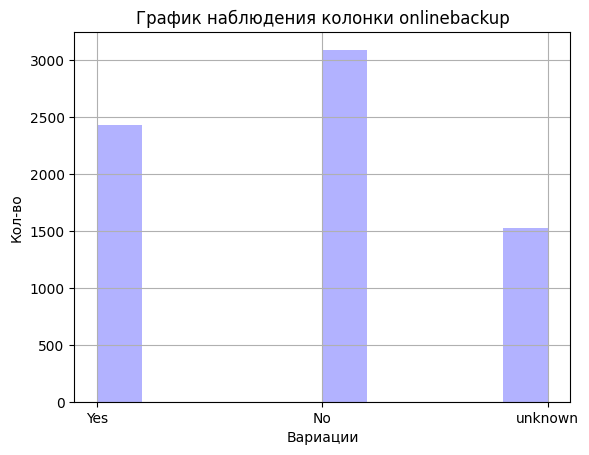

No         3094
Yes        2418
unknown    1520
Name: deviceprotection, dtype: int64


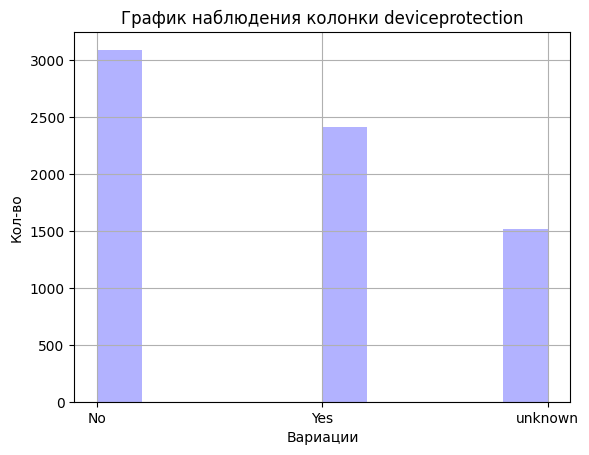

No         3472
Yes        2040
unknown    1520
Name: techsupport, dtype: int64


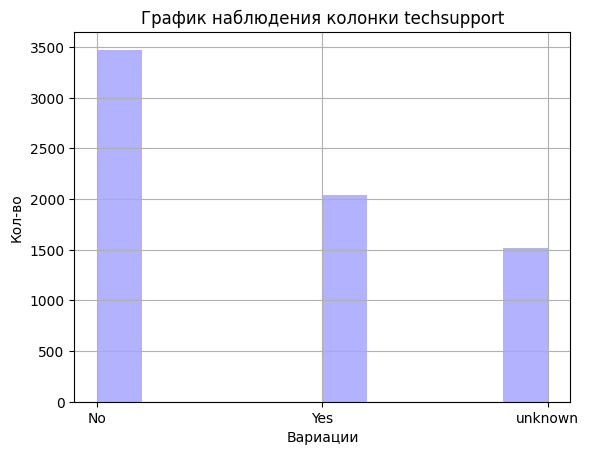

No         2809
Yes        2703
unknown    1520
Name: streamingtv, dtype: int64


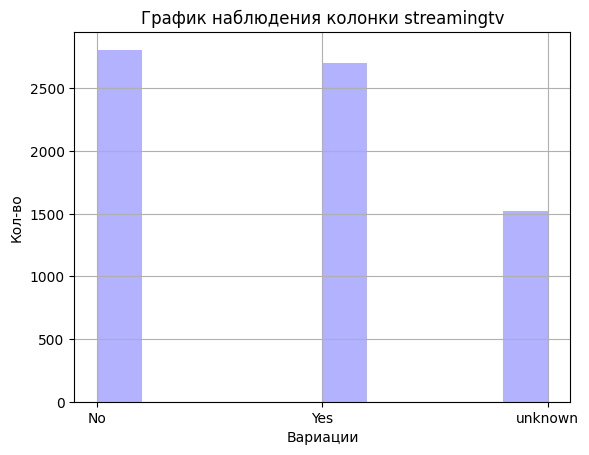

No         2781
Yes        2731
unknown    1520
Name: streamingmovies, dtype: int64


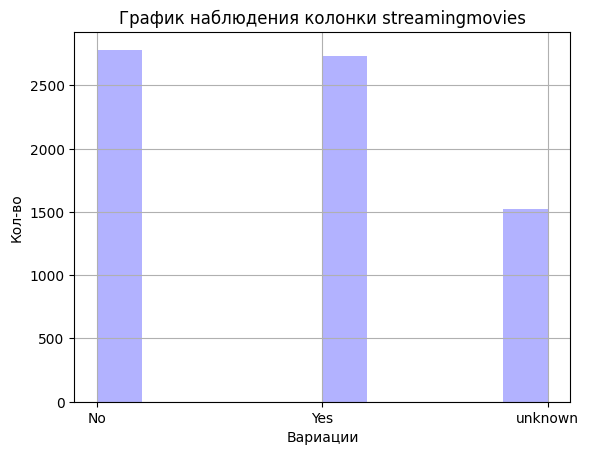

No         3385
Yes        2967
unknown     680
Name: multiplelines, dtype: int64


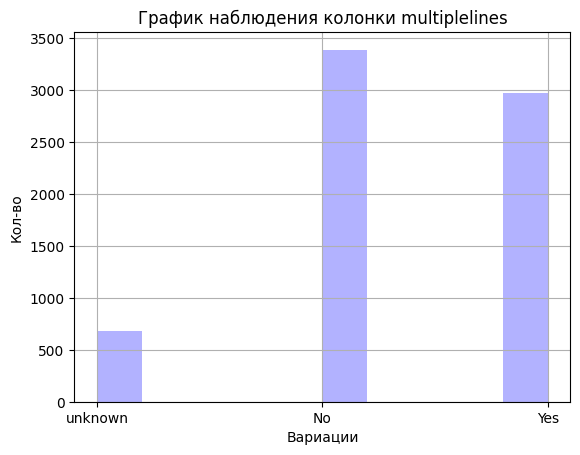

In [ ]:
data_3 = data_2[['type',
                 'paymentmethod',
                 'gender',
                 'partner',
                 'dependents',
                 'internetservice',
                 'onlinesecurity',
                 'onlinebackup',
                 'deviceprotection',
                 'techsupport',
                 'streamingtv',
                 'streamingmovies',
                 'multiplelines']]


for col in data_3.columns:
    print(data_3[col].value_counts())
    data_3[col].hist(color='blue', alpha=0.3)
    plt.title(f'График наблюдения колонки {col}')
    plt.xlabel('Вариации')
    plt.ylabel('Кол-во')
    plt.show()

### Проведя анализ выяснилось что большинство клиентов телеком-компании:
  - **Чаще** заключают договора на ежемесячную оплату,
      - платят онлайн, остальные способы равновесны
      - у клиента нет иждивенца
      - используют оптоволоконный кабель
  - **Равное** количество клиентов мужчин и женщин
      - кол-во имеющих и не имеющих партнера клиентов
      - использует стриминговое телевидение и фильмы
  - **Реже** подключает блокировку опасных сайтов
      - использует антивирус
      - использует облачное хранилище данных
      - подключает выделенную линию поддержки
      - использует ведение параллельных линий для переговора

In [ ]:
del data_3

### Анализ численных признаков

In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   begindate         7032 non-null   datetime64[ns]
 2   enddate           7032 non-null   object        
 3   type              7032 non-null   object        
 4   paperlessbilling  7032 non-null   object        
 5   paymentmethod     7032 non-null   object        
 6   monthlycharges    7032 non-null   float64       
 7   totalcharges      7032 non-null   object        
 8   gender            7032 non-null   object        
 9   seniorcitizen     7032 non-null   int64         
 10  partner           7032 non-null   object        
 11  dependents        7032 non-null   object        
 12  internetservice   7032 non-null   object        
 13  onlinesecurity    7032 non-null   object        
 14  onlinebackup      7032 n

Заменяем тип данных **totalcharges** на на числовой

In [ ]:
data_2['totalcharges'] = data_2.totalcharges.astype('float64')

20.05     61
19.90     44
19.95     44
19.85     44
19.65     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: monthlycharges, Length: 1584, dtype: int64


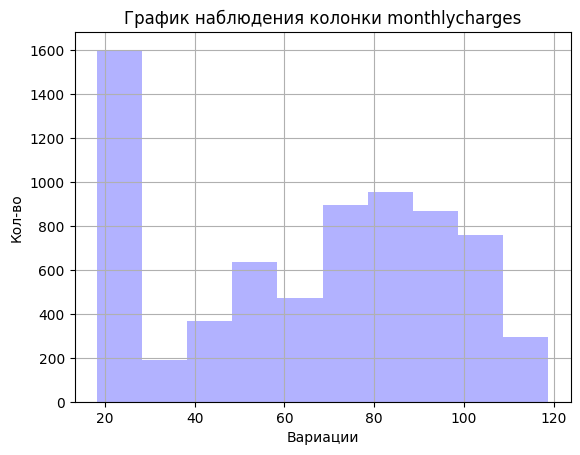

20.45      6
101.00     5
21.53      4
1007.50    4
732.60     4
          ..
4357.50    1
3509.55    1
2530.80    1
2599.10    1
7251.82    1
Name: totalcharges, Length: 6657, dtype: int64


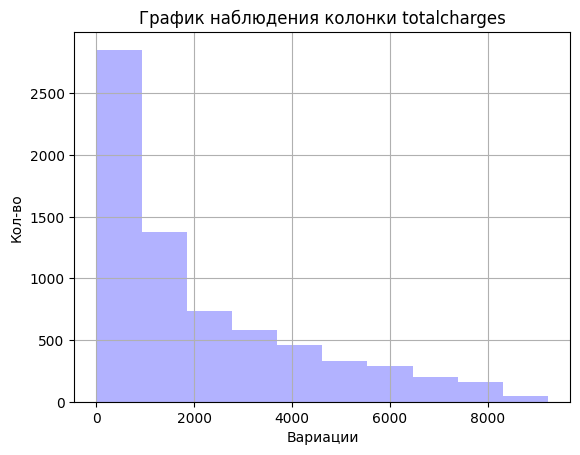

In [ ]:
data_3 = data_2[['monthlycharges', 'totalcharges']]


for col in data_3.columns:
    print(data_3[col].value_counts())
    data_3[col].hist(color='blue', alpha=0.3)
    #plt.figure(figsize=(7, 5))
    plt.title(f'График наблюдения колонки {col}')
    plt.xlabel('Вариации')
    plt.ylabel('Кол-во')
    plt.show()

In [ ]:
data = data_2.copy()

In [ ]:
del data_2

**Ревью:**
 - Чаще срок существования клиента это полтора - два года, медиана 2.0 г
 - На втором графике видно что из тех кто покидает компанию - чаще одни клиенты сменяются другими - по истечению двухгодичного перида потому что основной объем платежей приходится до отметки 2000 ед, все что больше это клиенты с большим стажем (6 лет)

### **Подготовка к обучению**

In [ ]:
data.enddate_encode.value_counts()

No     5931
Yes    1101
Name: enddate_encode, dtype: int64

In [ ]:
data['enddate_encode'] = data.enddate_encode.replace({'Yes': 1, 'No': 0})

In [ ]:
data.enddate_encode.value_counts()

0    5931
1    1101
Name: enddate_encode, dtype: int64

Делим датасет на две выборки train/test(0.25)

In [ ]:
X = data.drop(['enddate',
               'enddate_encode',
               'encode',
               'begindate',
               'start_month',
               'end_month',
               'customerid'], axis=1)

y = data['enddate_encode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5274, 18)
(1758, 18)
(5274,)
(1758,)


In [ ]:
X_train.sample()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,duration_days
223,Month-to-month,No,Mailed check,50.05,357.36,Male,0,Yes,No,DSL,No,No,No,Yes,No,No,No,215


In [ ]:
y_train.value_counts()

0    4460
1     814
Name: enddate_encode, dtype: int64

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 6772 to 6097
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              5274 non-null   object 
 1   paperlessbilling  5274 non-null   object 
 2   paymentmethod     5274 non-null   object 
 3   monthlycharges    5274 non-null   float64
 4   totalcharges      5274 non-null   float64
 5   gender            5274 non-null   object 
 6   seniorcitizen     5274 non-null   int64  
 7   partner           5274 non-null   object 
 8   dependents        5274 non-null   object 
 9   internetservice   5274 non-null   object 
 10  onlinesecurity    5274 non-null   object 
 11  onlinebackup      5274 non-null   object 
 12  deviceprotection  5274 non-null   object 
 13  techsupport       5274 non-null   object 
 14  streamingtv       5274 non-null   object 
 15  streamingmovies   5274 non-null   object 
 16  multiplelines     5274 non-null   objec

### **OneHotEncoder**


In [ ]:
# категориальные признаки для линейных моделей
ohe_features_LR = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_LR)

['type', 'paperlessbilling', 'paymentmethod', 'gender', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']


In [ ]:
# категориальные признаки для регрессии/буст
ohe_features_reg = ohe_features_LR.copy()
ohe_features_reg.remove('paymentmethod')
print(ohe_features_reg)

['type', 'paperlessbilling', 'gender', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']


In [ ]:
# численные признаки
numeric = X_train.select_dtypes(exclude='object').columns.to_list()
numeric.remove('seniorcitizen') # бинарный категориальный
print(numeric)

['monthlycharges', 'totalcharges', 'duration_days']


In [ ]:
X_train_LR = X_train.copy()
X_train_reg = X_train.copy()

In [ ]:
transform_category =  make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='error'),
        ohe_features_LR),
    (StandardScaler(),
        numeric),)

In [ ]:
X_train_transform = transform_category.fit_transform(X_train_LR)
X_train_transform

array([[ 1.        ,  0.        ,  1.        , ..., -0.06978351,
        -0.32948982, -0.3461944 ],
       [ 0.        ,  0.        ,  1.        , ...,  0.99132567,
        -0.11064747, -0.43273778],
       [ 0.        ,  0.        ,  1.        , ...,  1.38738508,
         2.06297659,  1.39640798],
       ...,
       [ 0.        ,  0.        ,  1.        , ..., -1.44774021,
        -0.90537781, -0.87865623],
       [ 0.        ,  1.        ,  1.        , ...,  0.62332046,
         0.80649069,  0.72459663],
       [ 0.        ,  1.        ,  0.        , ...,  0.54740908,
         1.75072569,  1.88633154]])

In [ ]:
X_train_transform_sparse = csr_matrix(X_train_transform)

In [ ]:
X_train_encoder = pd.DataFrame.sparse.from_spmatrix(X_train_transform_sparse,
    columns=transform_category.get_feature_names_out())

In [ ]:
X_train_encoder.sample(3)

,onehotencoder__type_One year,onehotencoder__type_Two year,onehotencoder__paperlessbilling_Yes,onehotencoder__paymentmethod_Credit card (automatic),onehotencoder__paymentmethod_Electronic check,onehotencoder__paymentmethod_Mailed check,onehotencoder__gender_Male,onehotencoder__partner_Yes,onehotencoder__dependents_Yes,onehotencoder__internetservice_Fiber optic,...,onehotencoder__techsupport_unknown,onehotencoder__streamingtv_Yes,onehotencoder__streamingtv_unknown,onehotencoder__streamingmovies_Yes,onehotencoder__streamingmovies_unknown,onehotencoder__multiplelines_Yes,onehotencoder__multiplelines_unknown,standardscaler__monthlycharges,standardscaler__totalcharges,standardscaler__duration_days
3879,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.474144,-0.993065,-1.282036
1475,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.233862,0.482745,0.635120
1032,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.672124,-0.898415,-1.103082


In [ ]:
X_train_encoder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5274 entries, 0 to 5273
Data columns (total 28 columns):
 #   Column                                                Non-Null Count  Dtype             
---  ------                                                --------------  -----             
 0   onehotencoder__type_One year                          5274 non-null   Sparse[float64, 0]
 1   onehotencoder__type_Two year                          5274 non-null   Sparse[float64, 0]
 2   onehotencoder__paperlessbilling_Yes                   5274 non-null   Sparse[float64, 0]
 3   onehotencoder__paymentmethod_Credit card (automatic)  5274 non-null   Sparse[float64, 0]
 4   onehotencoder__paymentmethod_Electronic check         5274 non-null   Sparse[float64, 0]
 5   onehotencoder__paymentmethod_Mailed check             5274 non-null   Sparse[float64, 0]
 6   onehotencoder__gender_Male                            5274 non-null   Sparse[float64, 0]
 7   onehotencoder__partner_Yes                

## Обучение моделей

### **LogisticRegression**

In [ ]:
%%time

model_LR = LogisticRegression (random_state=RANDOM_STATE)
params = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg'],
    'penalty' : ['l1', 'l2']

}
gs = GridSearchCV(model_LR,
                  params,
                  cv=5,
                  scoring='roc_auc',
                  verbose=False).fit(X_train_encoder, y_train)
roc_score_LR = gs.best_score_
best_params = gs.best_params_

CPU times: user 2.51 s, sys: 12.7 ms, total: 2.52 s
Wall time: 2.52 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver

In [ ]:
print("Лучший результат ROC_AUC:", roc_score_LR)
print("Лучшие параметры модели:", best_params)

Лучший результат ROC_AUC: 0.7686024188007278
Лучшие параметры модели: {'penalty': 'l1', 'solver': 'liblinear'}


## **RandomForestClassifier**

In [ ]:
%%time

model_RF = RandomForestClassifier(random_state=RANDOM_STATE)

parametrs = {
    'n_estimators': range(50, 110, 10),
    'criterion': ['gini'],
    'max_depth': range(2, 10, 2),
    'min_samples_split': range(2, 8, 2),
    'min_samples_leaf': range(2, 8, 2)
}


grid_RF = GridSearchCV(model_RF,
                       parametrs,
                       cv=5,
                       scoring='roc_auc',
                       n_jobs=1,
                       verbose=False).fit(X_train_encoder, y_train)


roc_score_RF = grid_RF.best_score_
best_params_RF = grid_RF.best_params_


CPU times: user 8min 11s, sys: 1.25 s, total: 8min 12s
Wall time: 8min 15s


In [ ]:
print("Лучшее значение ROC_AUC:", roc_score_RF)
print("Лучшие параметры модели:", best_params_RF)

Лучшее значение ROC_AUC: 0.8211362820448811
Лучшие параметры модели: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}


##**LGBMClassifier**

In [ ]:
%%time

model_LG = lgb.LGBMClassifier(random_state=RANDOM_STATE,
                              error_score='raise',
                              verbose=1)
parameters = {'depth': range(3, 12),
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'n_estimators': range(100, 550, 50)}

grid_LG = GridSearchCV(model_LG,
                        parameters,
                        cv=5,
                        scoring='roc_auc',
                        n_jobs=1,
                        verbose=False).fit(X_train_encoder, y_train)


roc_score_LG = grid_LG.best_score_
best_params_LG = grid_LG.best_params_

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Info] Number of positive: 651, number of negative: 3568
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154302 -> initscore=-1.701251
[LightGBM] [Info] Start training from score -1.701251
[LightGBM] [Warning] Unknown parameter: error_score
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Found whitespace in feature_names

In [ ]:
print("Лучшее значение ROC_AUC:", roc_score_LG)
print("Лучшие параметры модели:", best_params_LG)

Лучшее значение ROC_AUC: 0.8773243800073974
Лучшие параметры модели: {'depth': 3, 'learning_rate': 0.1, 'n_estimators': 400}


### **CatBoostClassifier**

In [ ]:
#обозначаем object для котофичей
cat = X_train.select_dtypes(include='object').columns.to_list()
print(cat)

['type', 'paperlessbilling', 'paymentmethod', 'gender', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']


In [ ]:
%%time

model_Cat = CatBoostClassifier(random_state = RANDOM_STATE,
                               cat_features=cat)
parameters = {'learning_rate': [0.03, 0.1],
              'depth': [5, 10],
              'l2_leaf_reg': [3, 5]}


grid_Cat = GridSearchCV(model_Cat,
                        parameters,
                        cv=5,
                        scoring='roc_auc',
                        n_jobs=1,
                        verbose=False).fit(X_train, y_train)


roc_score_Cat = grid_Cat.best_score_
best_params_Cat = grid_Cat.best_params_

Выходные данные были обрезаны до нескольких последних строк (5000).
2:	learn: 0.5147206	total: 82.6ms	remaining: 27.4s
3:	learn: 0.4749086	total: 140ms	remaining: 35s
4:	learn: 0.4493991	total: 153ms	remaining: 30.4s
5:	learn: 0.4360701	total: 156ms	remaining: 25.9s
6:	learn: 0.4252469	total: 164ms	remaining: 23.3s
7:	learn: 0.4101367	total: 178ms	remaining: 22s
8:	learn: 0.4019507	total: 186ms	remaining: 20.5s
9:	learn: 0.3969753	total: 191ms	remaining: 18.9s
10:	learn: 0.3799858	total: 262ms	remaining: 23.6s
11:	learn: 0.3664160	total: 320ms	remaining: 26.4s
12:	learn: 0.3571473	total: 378ms	remaining: 28.7s
13:	learn: 0.3466276	total: 439ms	remaining: 30.9s
14:	learn: 0.3395621	total: 513ms	remaining: 33.7s
15:	learn: 0.3381412	total: 522ms	remaining: 32.1s
16:	learn: 0.3322947	total: 602ms	remaining: 34.8s
17:	learn: 0.3245763	total: 737ms	remaining: 40.2s
18:	learn: 0.3172723	total: 872ms	remaining: 45s
19:	learn: 0.3125421	total: 1s	remaining: 49.3s
20:	learn: 0.3059584	total: 1.

In [ ]:
print("Лучшее значение ROC_AUC:", roc_score_Cat)
print("Лучшие параметры модели:", best_params_Cat)

Лучшее значение ROC_AUC: 0.9040237152243901
Лучшие параметры модели: {'depth': 5, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


### Результаты моделей

In [ ]:
result_models = pd.Series({
    "LogisticRegression" : roc_score_LR,
    "RandomForest" : roc_score_RF,
    "CatBoost" : roc_score_Cat,
    "LGBMClassifier" : roc_score_LG})
print(result_models)

LogisticRegression    0.768602
RandomForest          0.821136
CatBoost              0.904024
LGBMClassifier        0.877324
dtype: float64


Тестируем лучшую - CatBoost

# Тестирование моделей

In [ ]:
model_test_Cat = CatBoostClassifier(random_state=RANDOM_STATE,
                                learning_rate=best_params_Cat['learning_rate'],
                                depth=best_params_Cat['depth'],
                                l2_leaf_reg=best_params_Cat['l2_leaf_reg'],
                                cat_features=cat)

In [ ]:
cat_test = model_test_Cat
cat_test.fit(X_train, y_train)

0:	learn: 0.6169318	total: 26.2ms	remaining: 26.2s
1:	learn: 0.5559654	total: 49.6ms	remaining: 24.8s
2:	learn: 0.5230213	total: 61.9ms	remaining: 20.6s
3:	learn: 0.4892966	total: 89.5ms	remaining: 22.3s
4:	learn: 0.4569224	total: 189ms	remaining: 37.5s
5:	learn: 0.4331285	total: 238ms	remaining: 39.5s
6:	learn: 0.4164030	total: 287ms	remaining: 40.7s
7:	learn: 0.4075529	total: 310ms	remaining: 38.4s
8:	learn: 0.4002725	total: 325ms	remaining: 35.8s
9:	learn: 0.3896596	total: 371ms	remaining: 36.8s
10:	learn: 0.3782759	total: 421ms	remaining: 37.8s
11:	learn: 0.3698614	total: 486ms	remaining: 40s
12:	learn: 0.3634849	total: 534ms	remaining: 40.5s
13:	learn: 0.3575449	total: 560ms	remaining: 39.5s
14:	learn: 0.3540776	total: 603ms	remaining: 39.6s
15:	learn: 0.3504618	total: 630ms	remaining: 38.7s
16:	learn: 0.3465618	total: 653ms	remaining: 37.8s
17:	learn: 0.3455301	total: 666ms	remaining: 36.3s
18:	learn: 0.3426219	total: 705ms	remaining: 36.4s
19:	learn: 0.3405148	total: 736ms	remai

0.9139815764477932

In [ ]:
predicted_cat = roc_auc_score(y_test, cat_test.predict_proba(X_test)[:,1])
print('Тестовый roc_auc:', predicted_cat)

Тестовый roc_auc: 0.9139815764477932


### ***Roc_Auc на тестовой выборке 0.91***


## **Определение важности признаков**


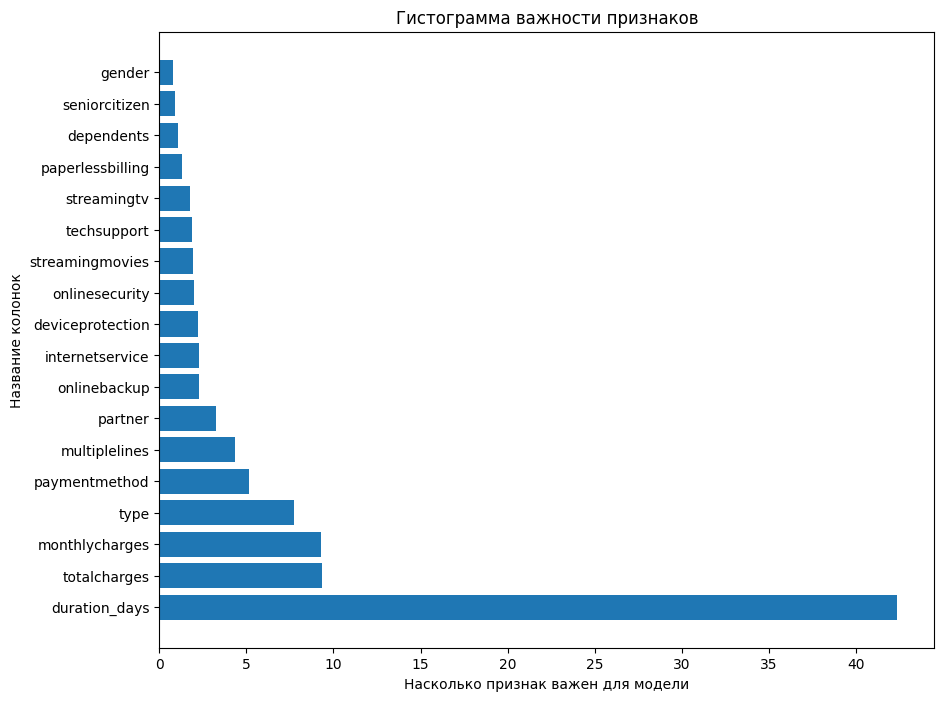

In [ ]:
names = X_test.columns
importances = cat_test.get_feature_importance()

feature_importance_dict = dict(zip(names, importances))

sort = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names = [feature for feature, importance in sort]
sorted_importances = [importance for feature, importance in sort]

plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Насколько признак важен для модели')
plt.ylabel('Название колонок')
plt.title('Гистограмма важности признаков')
plt.show()


## **Матрица ошибок**

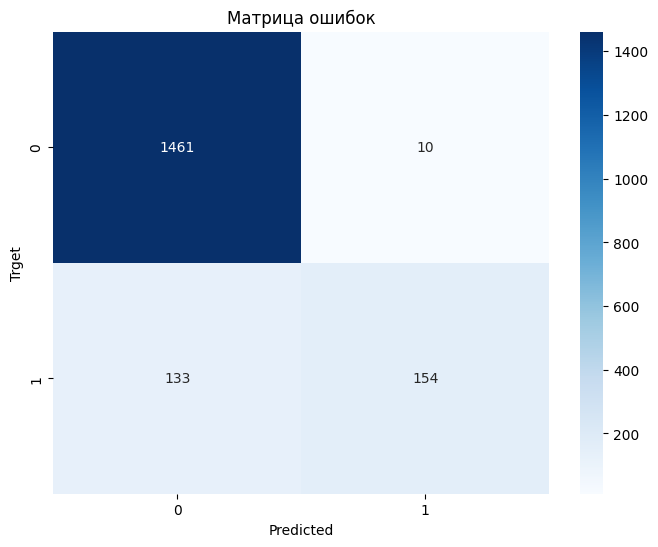

In [ ]:
cm = confusion_matrix(y_test, cat_test.predict(X_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Матрица ошибок')
plt.xlabel('Predicted')
plt.ylabel('Trget')
plt.show()

- TP (True Positives) 1461
- FP (False Positives) 133
- FN (False Negatives) 10
- TN (True Negatives) 154

# **Заключение**

**В ходе разработки модели предсказания были выполнены следующие этапы:**
  - Разделение на выборки методом train_test_split
  - Выполено кодирование категориальных признаков методом OneHotEncoder
  - Масштабирование числовых признаков StandartScaler
  - Подобраны гиперпараметры для 4-х моделей:
      - LogisticRegression
      - RandomForestClassifier
      - LGBMClassifier
      - CatBoostClassifier
       помощью GridSearchCV с кросс-валидацией
  - Определили по метрике roc_auc (0.90) *лучшую модель* **CatBoost**
  - Протестировали лучшую модель с выходной метрикой **roc_auc 0.91**
  - построена гистограмма важности признаков для модели, топ 3 для нее это: duration_days, total_charges, monthly_charges
  - построена матрица ошибок, из которой видно что модель качественная
  - Вопросов нет.

# **Отчет по решению задачи**

В ходе проекта была поставлена и выполнена задача разработки модели классификации для предсказания оттока клиента телеком компании. Модель разработана в процессе следующих основных этапов:
  - предобработки данных
  - создании модели
  - тестировании лучшей
  - определение важности признаков и матрица ошибок

В качестве ключевой метрики используется ROC_AUC (это удачный выбор метрики, поскольку на нее не влияет дисбаланс классов)

В **предобработку** данных входили следующие этапы:
  - объединение трех предоставленных датасетов в один с помощью merge
  - приведение колонок к нижнему регистру (
      для удобства)
  - создан новый признак:
    - количество дней клиента в компании, по которому стало понятно что медиана нахождения клиента в компании 2 года, а максимальное 6 лет. Только 15.6% клиентов разрывают контракт в первые два года сотрудничества.

    
  - Сделан анализ пользователя:
    - *Чаще* заключают договора на ежемесячную оплату,
      - платят онлайн, остальные способы равновесны
      - у клиента нет иждивенца
      - используют оптоволоконный кабель
    - *Равное* количество клиентов мужчин и женщин
      - кол-во имеющих и не имеющих партнера клиентов
      - использует стриминговое телевидение и фильмы
    - *Реже* подключает блокировку опасных сайтов
      - использует антивирус
      - использует облачное хранилище данных
      - подключает выделенную линию поддержки
      - использует ведение параллельных линий для переговора

  - Провели замену типов данных для исследовательского анализа данных и постоения графиков

В этапе разработки модели было три этапа:
  1. Подготовка к обучению
    - таргетный признак EndDate включал в себя два типа данных объект и дата. Методом replace была произведена кодировка данных на 1-0
    - разделение на выборки train_test_split, с объемом тестовой 0.25
    - Была осуществлена кодировка тренировочного датасета методом OneHotEncoder, и масштабиованы числовые признаки StandartScaler.
      Для обучения были испольованы следующие закодированные признаки: type_One year, type_Two year, paperlessbilling_Yes,paymentmethod_Credit card (automatic), paymentmethod_Electronic check, paymentmethod_Mailed check,gender_Male,partner_Yes,dependents_Yes, internetservice_Fiber optic,internetservice_unknown, onlinesecurity_Yes, onlinesecurity_unknown, onlinebackup_Yes, onlinebackup_unknown,deviceprotection_Yes,deviceprotection_unknown, techsupport_Yes, techsupport_unknown,streamingtv_Yes,streamingtv_unknown,streamingmovies_Yes, streamingmovies_unknown,multiplelines_Yes,multiplelines_unknown, monthlycharges,totalcharges,duration_days.
  2. Разработка и обучение моделей с подбором гиперпараметров и кроссвалидацией с помощью  GridSearchCV :
    - **Logistic Regression**
        - Лучший результат **ROC_AUC**: 0.76
        - Лучшие параметры модели: {'penalty': 'l1', 'solver': 'liblinear'}
    - **RandomForestClaffifier**
        - Лучшее значение **ROC_AUC**: 0.82
        - Лучшие параметры модели: {'criterion': 'gini','max_depth': 8,
        'min_samples_leaf': 6,
        'min_samples_split': 2,
        'n_estimators': 100}

    - **LGBMClassifier**
        - Лучшее значение **ROC_AUC**: 0.87
        - Лучшие параметры модели: {'depth': 3, 'learning_rate': 0.1, 'n_estimators': 400}

    - **CatBoostClassifier**
        - Лучшее значение **ROC_AUC**: 0.9040237152243901
        - Лучшие параметры модели: {'depth': 5, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

  3. В ходе тестирования была выбрала модель CatBoostClassifier с параметрами 'depth': 5, 'l2_leaf_reg': 3 и 'learning_rate': 0.1 и тестирование было пройдено успешно с **конечным** значением ключевой метрики **ROC_AUC 0.91**

Построив график *определения важности признаков* было выяснено что модель в основном опирается на эти основные признаки (по возрастанию):
  - paymentmethod
  - type
  - monthly_charges
  - total_charges,
  - duration_days

Трудности возникшие по ходу работы были незначительные в основном связанные с освоением кодировщика и разницы версий библиотек в визуализаторах. Справиться помогла смена JupiterHub на Colab

По матрице ошибок выяснили что TP (True Positives) 1461, FP (False Positives) 133, FN (False Negatives) 10, TN (True Negatives) 154 - это говорит о том что правильность предсказания превышает ошибки. Разработанную модель можно считать адекватной.